# Create DataFrame of compressed SCALED correlation matrices

In previous attempts the clustering algorithms where applied on DataFrames consisting of correlation matrices
which are scaled with **StandardScaler** and compressed with **PCA**.
clustering

This might be due the fact that the clustering algorithms cluster the correlation matrices according to absolute values and not according to the pattern of the matrices.

**Here**

**Normalize** each correlation matrix so that we only sort the correlation matrices according to their patterns. Then apply **StandardScaler** and **PCA**.

In [1]:
import re
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import helper_fcts

### 1 Load parameter and test correlation DataFrame

In [2]:
df_par = pd.read_pickle('df_parameter.p')

In [3]:
# test correlation matrix

if False:
    df_corr = pd.read_pickle('data/df_corr.p')
    
    ind = 0 # index of corr mat
    
    # load original matrix and restore saved upper triangular matrix
    mat_ori = np.load(df_par.loc[ind, "path"] + '/correlation_fct_BC.npz')['corrBC']
    mat_build = helper_fcts.flat_triu_to_full_matrix(df_corr.loc[ind, :], N=200)

    # make a comparison plot
    helper_fcts.plot_comparison_betw_2_mats(
        mat1=mat_ori,
        mat2=mat_build,
        x_grid = np.linspace(-100, 100, 200),
        ax1_title='$\mathcal{C}_{\mathrm{ori}}$',
        ax2_title=r'$\mathcal{C}_{\mathrm{triu}}$',
        ax3_title=r'$|\mathcal{C}_{\mathrm{ori}} - \mathcal{C}_{\mathrm{triu}}|$',
        main_title='test',
        fig_name=None
    )

### 2 Normalize Correlation Matrices

First we obtain a list of min-max ranges for each correlation matrix:

In [4]:
if False:
    # perform only once
    df_corr = pd.read_pickle('data/df_corr.p')

    ranges = (df_corr.max(axis=1) - df_corr.min(axis=1)).abs()

    for i, row in df_corr.iterrows():
        df_corr.loc[i, :] = row / ranges[i]

    df_corr.to_pickle(f'data/df_corr_normed.p')
    
    # to save memory df_corr is modified in place
    # continue with df_corr_normed
    exit
else:
    
    df_corr_normed = pd.read_pickle('data/df_corr_normed.p')

Check how this normalization impact the matrices

In [5]:
if False:
    
    ind = 900 # index of corr mat
    
    # load original matrix and restore saved upper triangular matrix
    mat_ori = np.load(df_par.loc[ind, "path"] + '/correlation_fct_BC.npz')['corrBC']
    mat_build = helper_fcts.flat_triu_to_full_matrix(df_corr_normed.loc[ind, :], N=200)

    # make a comparison plot
    helper_fcts.plot_comparison_betw_2_mats(
        mat1=mat_ori,
        mat2=mat_build,
        x_grid = np.linspace(-100, 100, 200),
        ax1_title='$\mathcal{C}_{\mathrm{ori}}$',
        ax2_title=r'$\mathcal{C}_{\mathrm{normed}}$',
        ax3_title=r'can be ignored',
        main_title='test',
        separate_cbars=True,
        fig_name=None
    )

### 3 Scale and reduce dimensionality of correlation matrices

In [6]:
n_comp = 50

pipe_pca = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=n_comp, random_state=42))
])

arr_corr = pipe_pca.fit_transform(df_corr_normed)

In [7]:
expl_var = pipe_pca.named_steps['pca'].explained_variance_ratio_

print('Explained variance:', sum(expl_var))

Explained variance: 0.938212753230895


In [8]:
# needed to reconstruct decomposed correlation matrices
corr_backscaled = np.dot(arr_corr, pipe_pca.named_steps['pca'].components_)

corr_backscaled = pipe_pca.named_steps['std'].inverse_transform(corr_backscaled)

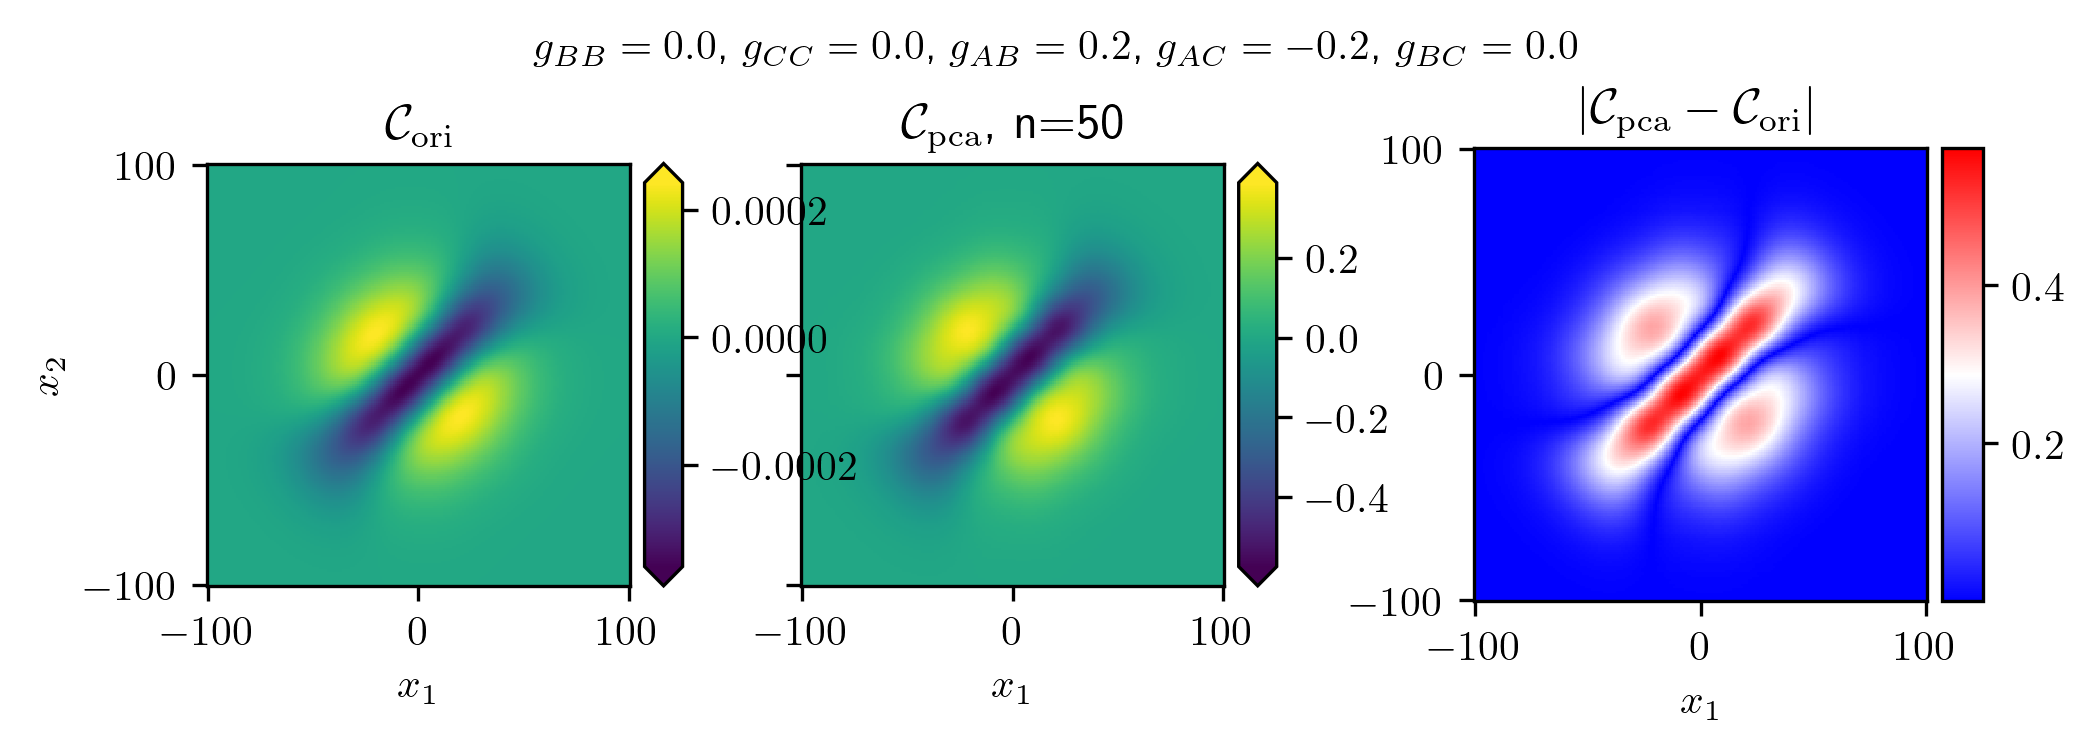

In [9]:
index = helper_fcts.get_index(df_par, gBB=0.0, gCC=0.0, gAB=0.2, gAC=-0.2, gBC=0.0)


helper_fcts.plot_backscaled_comparison(df_par, corr_backscaled, index=index, pca_n=n_comp, bool_save=True)
helper_fcts.plot_backscaled_comparison(df_par, corr_backscaled, index=index, pca_n=n_comp, bool_save=False)


In [11]:
df_corr_pca = pd.DataFrame(arr_corr, columns=[f'pca comp {i}' for i in range(1, n_comp+1)])

df_main = pd.merge(
    left=df_par,
    right=df_corr_pca,
    how='inner',
    left_index=True,
    right_index=True
)
df_main.to_pickle(f'df_main_normed_std_pca_{n_comp}.p')